# 基于timestamp的事件重构a - DSSD-MWPC

Experiment: 188.2MeV $^{40}Ar+^{175}Lu$ fusion-evaporation @ SHANS, IMP

Detectors: MWPC+ DSSD(128x48) + SSD(1x3)
- SSD 数据没有包含在本课件的数据内.

靶上产生的熔合蒸发反应余核经过SHANS分离，穿过MWPC, 注入到DSSD表面。SSD作为轻粒子的veto。

DAQ: CAEN V1724 100MHz, 14bit digitizer

Trigger : self-trigger for all channels

![](shans.png)
![](focalplan.png)

In [1]:
TFile *fds=new TFile("dssd.root");
TTree *tree=(TTree*)fds->Get("tree");
TCanvas *c1=new TCanvas("c1","c1");
Double_t energy;
ULong64_t timestamp;
Int_t side,strip;
tree->SetBranchAddress("energy",&energy);
tree->SetBranchAddress("timestamp",&timestamp);
tree->SetBranchAddress("side",&side);
tree->SetBranchAddress("strip",&strip);
tree->Print();

******************************************************************************
*Tree    :tree      : dssd                                                   *
*Entries :   269955 : Total =         6499612 bytes  File  Size =    4793737 *
*        :          : Tree compression factor =   1.36                       *
******************************************************************************
*Br    0 :energy    : energy/D                                               *
*Entries :   269955 : Total  Size=    2166281 bytes  File Size  =    2163446 *
*Baskets :       68 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :timestamp : timestamp/l                                            *
*Entries :   269955 : Total  Size=    2166497 bytes  File Size  =    1904904 *
*Baskets :       68 : Basket Size=      32000 bytes  Compression=   1.14     *
*...................................................

### 事件的时间顺序:
从下面的语句执行结果可以看出，timestamp不按事件编号的增加而增加，即获取事件的顺序并非是按照事件的发生顺序进行记录的。因此需要将事件按照时间顺序进行排序，将正面和背面的信号按照时间关系进行匹配，重新组织事件结构。

In [2]:
tree->Scan("side:strip:timestamp:energy","","colsize=15",10,1);

************************************************************************************
*    Row   *            side *           strip *       timestamp *          energy *
************************************************************************************
*        1 *               0 *              14 *   2484394953520 * 4293.3485518628 *
*        2 *               1 *             110 *   3553975013340 * 6755.7254575675 *
*        3 *               1 *              41 *   1149167130120 * 2165.1559156333 *
*        4 *               0 *              15 *   3469034044010 *  6763.729120955 *
*        5 *               1 *              14 *    217811466190 * 994.30788063242 *
*        6 *               1 *             102 *   2051660598330 * 5173.9848570335 *
*        7 *               0 *              14 *   1928943248620 * 3068.8395709874 *
*        8 *               1 *             106 *   2414539135320 * 5698.1408220472 *
*        9 *               1 *             102 *   2897908302230 

### 正面和背面事件分别按照时间增加的顺序进行排序
利用c++定义的模板类中的map, 将timestamp作为map的key值，其他参数(side,strip,energy)作为value. 当map中插入(key,value)值时，map内按照key的增加顺序(缺省)进行自动排序。

In [3]:
//get timestamp table for front(side=0) and back(side=1) side
struct dssd
{
    Double_t energy;
    Int_t strip;
};
map<ULong64_t, dssd> mapf1, mapb;//map for front and back side
dssd ds;
Long64_t nentries = tree->GetEntriesFast();
for (Long64_t jentry=0; jentry<nentries;jentry++) {
    tree->GetEntry(jentry);
    ds.energy = energy;
    ds.strip = strip;
    if(side==0) mapf1.insert(pair<ULong64_t,dssd>(timestamp,ds));
    if(side==1) mapb.insert(pair<ULong64_t,dssd>(timestamp,ds));
    if(nentries%100000==0) cout<<jentry<<endl;
}
cout<<"Total number of frontside/backside events = "<<mapf1.size()<<" / "<<mapb.size()<<endl;    
fds->Close();

Total number of frontside/backside events = 111075 / 150381


### 以正面为例，查看事件的时间排序结果

 0       1339474350       1243591410  11     97   6141.5    609.7
 1       9022757640       1339474900   3     94   10898.4    6140.3
 2       9122771170       9022758220  24     48   18331.7    12394.7
 3       9202986900       9122771720  31    121   13594.9    18350.6
 4       9305276750       9202987450  27     76   10988.4    3868.6
 5       9418690000       9305277310  29     91   16461.8    10993.2
 6       9423589230       9418690560  37     79   18753.1    16449.1
 7       9441338680       9423589790  43    100   23666.8    18779.6
 8       9470639040       9441339240   8     94   15354.3    23665.6
 9       9531671070       9445831200  22     42   15308.4    1169.2
10       9655957710       9449732290  26     74   7575.8    813.0
11       9664140820       9470639600  46    124   4508.0    15331.8
12       9703733650       9492181880  40      4   13927.8    2167.5
13       9765656470       9531671620  40    108   7464.1    15325.0
14       9974541640       9534153370  34    11

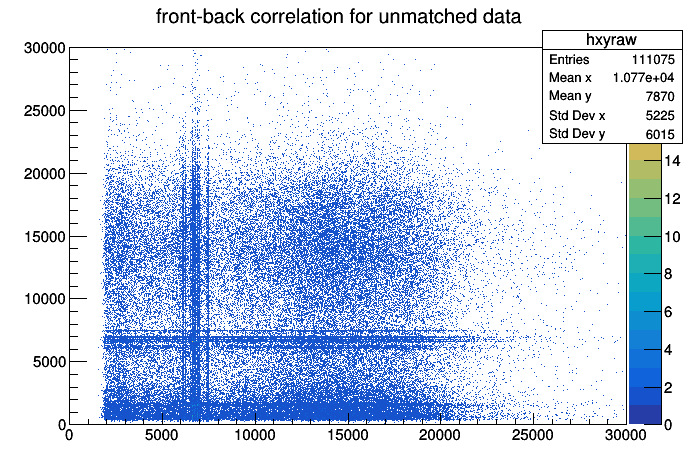

In [4]:
TString sout;
auto ifts=mapf1.begin();//map<ULong64_t, dssd>::iterator ifts=;
auto ibts=mapb.begin();
TH2F *hxyraw=new TH2F("hxyraw","front-back correlation for unmatched data",3000,0,30000,3000,0,30000);
for(int i=0; i<TMath::Min(mapf1.size(),mapb.size()); i++) {
    if(i<20) {
        sout.Form("%2d  %15llu  %15llu %3d    %3d   %5.1f    %5.1f"
                  , i, ifts->first, ibts->first, ifts->second.strip, ibts->second.strip, ifts->second.energy, ibts->second.energy);
       cout<<sout<<endl;
    }
    hxyraw->Fill(ifts->second.energy,ibts->second.energy);
    ifts++;
    ibts++;
}
hxyraw->Draw("colz");
c1->Draw();

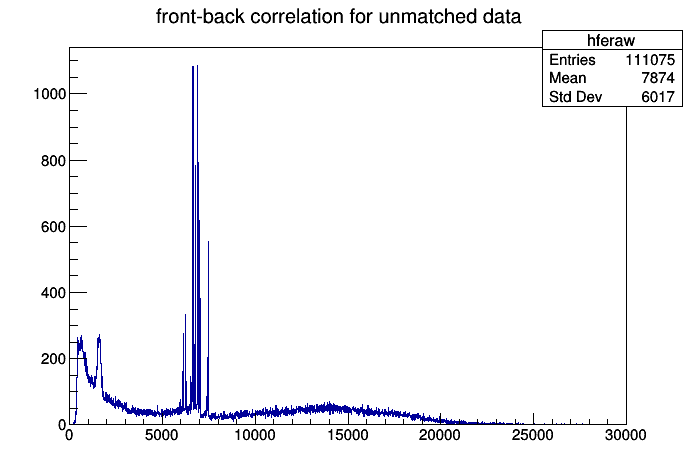

In [5]:
TH1F *hferaw1=(TH1F*) hxyraw->ProjectionY("hferaw");
hferaw1->Draw();
c1->Draw();

### 寻找正面和背面的符合时间窗
当多个探测器或一个探测器的不同信号是由一个事件(如某一入射粒子)引发(称为关联事件)时，它们之间就会有稳定的时间关系，即它们之间的时间差的分布，集中在固定的范围，如时间差服从高斯分布。而对于不关联事件，探测器之间的时间差是任意的，因此时间差的分布是均匀分布。

map::lower_bound(key):返回map中第一个大于或等于key的迭代器指针

map::upper_bound(key):返回map中第一个大于key的迭代器指针

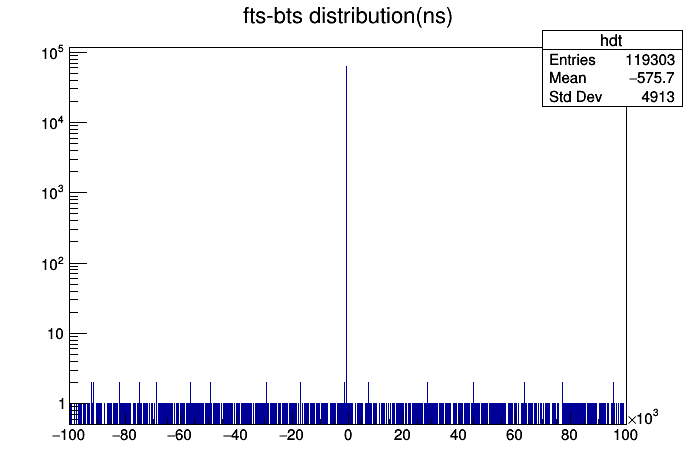

In [6]:
ULong64_t twindow=100000;//ns
ULong64_t toffset=0;//ns
TH1I *hdt=new TH1I("hdt","fts-bts distribution(ns)",20000,-100000,100000);
for(ifts=mapf1.begin(); ifts!=mapf1.end();ifts++) {
     ibts=mapb.lower_bound( (ifts->first-toffset)-twindow);
    while(ibts!=mapb.end()) {
        if(ibts->first >= (ifts->first-toffset) + twindow) break;
        int dt=(ifts->first-toffset)-ibts->first;
        hdt->Fill(dt);
        ibts++;
    }   
}
hdt->Draw();
c1->SetLogy();
c1->Draw();

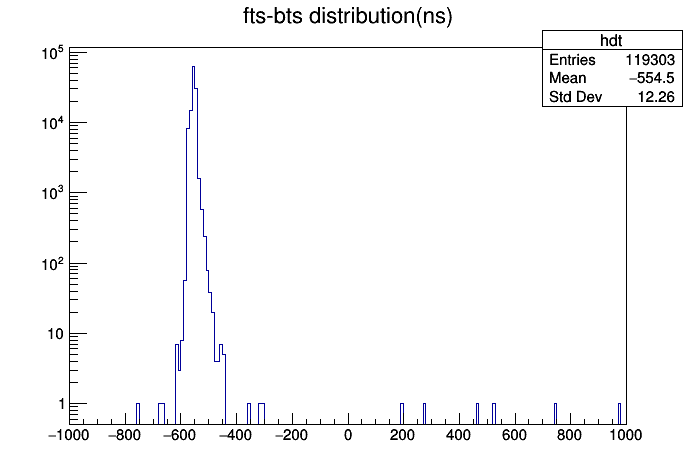

In [7]:
hdt->GetXaxis()->SetRangeUser(-1000,1000);
hdt->Draw();
c1->Draw();

### 从上图看符合时间窗中心位置为-550，宽度为-100,100
### 正面timestamp减去offset，将正背面时间对齐

In [8]:
toffset=-550;
map<ULong64_t,dssd> mapf;
for(auto ifts=mapf1.begin(); ifts!=mapf1.end();ifts++) 
    mapf.insert(pair<ULong64_t,dssd>(ifts->first - toffset, ifts->second));

### 在符合时间窗内观察正背面关联

In [9]:
TH2F *hxyc=new TH2F("hxyc","front-back correlation within coincidence window",3000,0,30000,3000,0,30000);

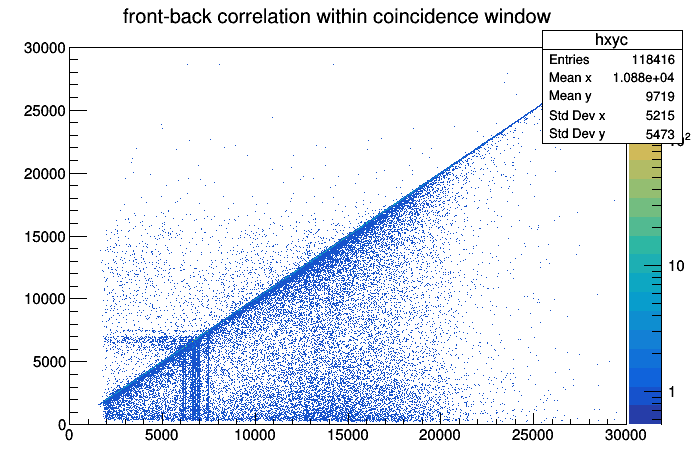

In [10]:
twindow=100;//ns
for(ifts=mapf.begin(); ifts!=mapf.end();ifts++) {
     ibts=mapb.lower_bound( (ifts->first)-twindow);
    while(ibts!=mapb.end()) {
        if(ibts->first >= (ifts->first) + twindow) break;
        int dt=ifts->first-ibts->first;
        hxyc->Fill(ifts->second.energy,ibts->second.energy);
        ibts++;
    }   
}
hxyc->Draw("colz");
c1->SetLogy(0);
c1->SetLogz();
c1->Draw();

### 正面相邻条之间事件关联

In [11]:
Int_t xhit,yhit;
Int_t xstrip[100],ystrip[100];
ULong64_t xtimestamp[100],ytimestamp[100];
Float_t xenergy[100],yenergy[100];
TH2F *hx2=new TH2F("hx2"," x0-x1 energy correlation",500,0,10000,500,0,10000);
TH1I *hdtx=new TH1I("hdtx"," tx0-tx1 ",20,-150,50);

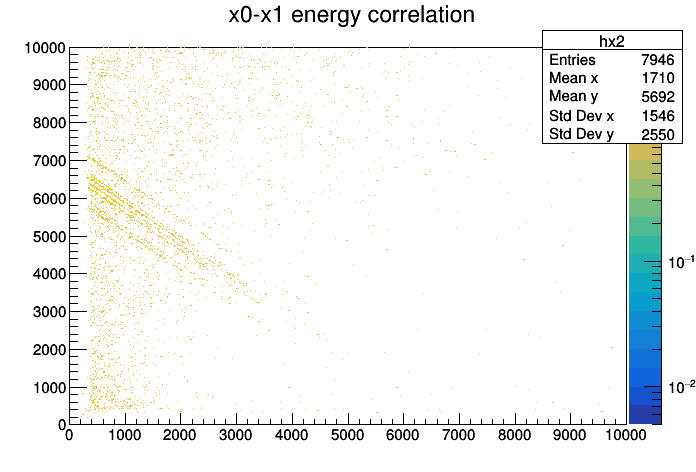

In [12]:
twindow=100;//ns
ifts=mapb.begin();
int nx[5];
while(ifts!=mapb.end() ) {        
        xhit=0;
        ULong64_t t0=ifts->first;
        while (ifts!=mapb.end() ) {
            if(ifts->first > t0+2*twindow) break;
            xtimestamp[xhit]= ifts->first;
            xstrip[xhit]= ifts->second.strip;
            xenergy[xhit]=ifts->second.energy;
            xhit++;
            ifts++;
        }
    
    if(xhit<5) nx[xhit]++;
    if(xhit==2) {
        hx2->Fill(xenergy[0],xenergy[1]);
        Int_t dt=xtimestamp[0]-xtimestamp[1];
        hdtx->Fill(dt);
    }
}
hx2->Draw("colz");
c1->SetLogy(0);
c1->Draw();

In [13]:
nx //mapf nx: { 0, 109946, 560, 3, 0 }

(int [5]) { 0, 134480, 7946, 3, 0 }


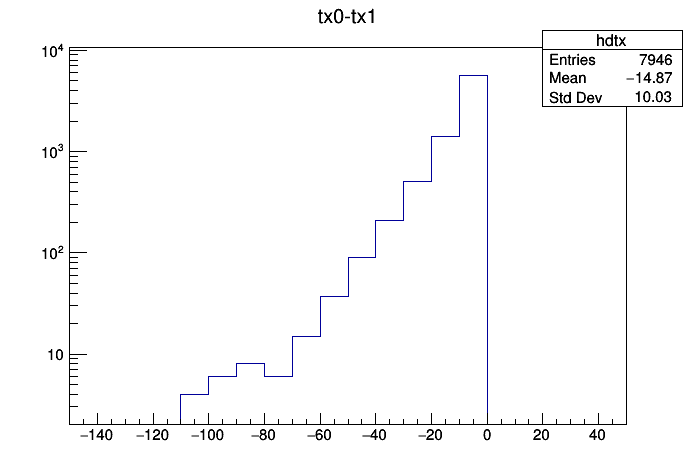

In [14]:
hdtx->Draw();
c1->SetLogy();
c1->Draw();//同一面，不同条之间的时间晃动在 +100-100 范围内

### 合并相邻条的两重事件，忽略三重事件


In [15]:
map<ULong64_t,dssd> mapfn,mapbn;
ULong64_t t0;
int mby[5],mfx[5];

In [16]:
twindow=100;//ns
ibts=mapb.begin();
while(ibts!=mapb.end() ) {        
        yhit=0;
        t0=ibts->first;
        while (ibts!=mapb.end() ) {
            if(ibts->first > t0+2*twindow) break;
            ytimestamp[yhit]= ibts->first;
            ystrip[yhit]= ibts->second.strip;
            yenergy[yhit]=ibts->second.energy;
            yhit++;
            ibts++;
        }
    if(yhit==1) {
        ds.strip=ystrip[0];
        ds.energy=yenergy[0];
        mapbn.insert(pair<ULong64_t,dssd>(ytimestamp[0],ds));
        mby[1]++;
    }
    if(yhit==2 && abs(ystrip[0]-ystrip[1])==1) {
        ds.energy=yenergy[0]+yenergy[1];
        ds.strip=ystrip[1];
        t0=ytimestamp[1];
        if(yenergy[0]>yenergy[1]) {
            ds.strip=ystrip[0];
            t0=ytimestamp[0];
        }
        mapbn.insert(pair<ULong64_t,dssd>(t0,ds));
        mby[2]++;
    }
    if(yhit==2 && abs(ystrip[0]-ystrip[1])>1) {    
        ds.strip=ystrip[0];
        ds.energy=yenergy[0];
        //mapbn.insert(pair<ULong64_t,dssd>(ytimestamp[0],ds));    
        ds.strip=ystrip[1];
        ds.energy=yenergy[1];
        //mapbn.insert(pair<ULong64_t,dssd>(ytimestamp[1],ds));  
        mby[3]++;
        }
}

In [17]:
mby

(int [5]) { 0, 134480, 7849, 97, 0 }


In [18]:
twindow=100;//ns
ifts=mapf.begin();
while(ifts!=mapf.end() ) {        
        xhit=0;
        t0=ifts->first;
        while (ifts!=mapf.end() ) {
            if(ifts->first > t0+2*twindow) break;
            xtimestamp[xhit]= ifts->first;
            xstrip[xhit]= ifts->second.strip;
            xenergy[xhit]=ifts->second.energy;
            xhit++;
            ifts++;
        }
    if(xhit==1) {
        ds.strip=xstrip[0];
        ds.energy=xenergy[0];
        mapfn.insert(pair<ULong64_t,dssd>(xtimestamp[0],ds));
        mfx[1]++;
    }
    if(xhit==2 && abs(xstrip[0]-xstrip[1])==1) {
        ds.energy=xenergy[0]+xenergy[1];
        ds.strip=xstrip[1];
        t0=xtimestamp[1];
        if(xenergy[0]>xenergy[1]) {
            ds.strip=xstrip[0];
            t0=xtimestamp[0];
        }
        mapfn.insert(pair<ULong64_t,dssd>(t0,ds));
        mfx[2]++;
    }
    if(xhit==2 && abs(xstrip[0]-xstrip[1])>1) {    
        ds.strip=xstrip[0];
        ds.energy=xenergy[0];
        //mapfn.insert(pair<ULong64_t,dssd>(xtimestamp[0],ds));    
        ds.strip=xstrip[1];
        ds.energy=xenergy[1];
        //mapfn.insert(pair<ULong64_t,dssd>(xtimestamp[1],ds));  
        mfx[3]++;
        }
}

In [19]:
mfx

(int [5]) { 0, 109946, 542, 18, 0 }


In [20]:
TH2F *hxy=new TH2F("hxy","front-back correlation for corrected data",3000,0,30000,3000,0,30000);
TH2F *hxyfbc=new TH2F("hxyfbc","front-back correlation for corrected data with f-b correlation",3000,0,30000,3000,0,30000);

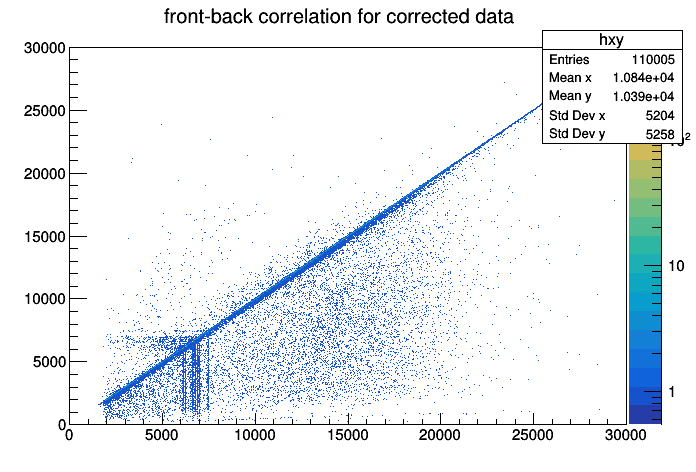

In [21]:
struct dssdxy
{
    int xstrip;
    int ystrip;
    Float_t energy;
};
dssdxy xy;
map<ULong64_t, dssdxy> mapdssd;
twindow=100;//ns
for(ifts=mapfn.begin(); ifts!=mapfn.end();ifts++) {
     ibts=mapbn.lower_bound( (ifts->first)-twindow);
    while(ibts!=mapbn.end()) {
        if(ibts->first >= (ifts->first) + twindow) break;
        int dt=ifts->first-ibts->first;
        hxy->Fill(ifts->second.energy,ibts->second.energy);
        if(abs(ifts->second.energy-ibts->second.energy)<50) {
            hxyfbc->Fill(ifts->second.energy,ibts->second.energy);
            xy.xstrip=ifts->second.strip;
            xy.ystrip=ibts->second.strip;
            xy.energy=ifts->second.energy;
            mapdssd.insert(pair<ULong64_t, dssdxy>(ifts->first, xy));
        }
        ibts++;
    }   
}
hxy->Draw("colz");
c1->SetLogy(0);
c1->SetLogz();
c1->Draw();

### 熔合蒸发反应余核的$\alpha-$衰变产物

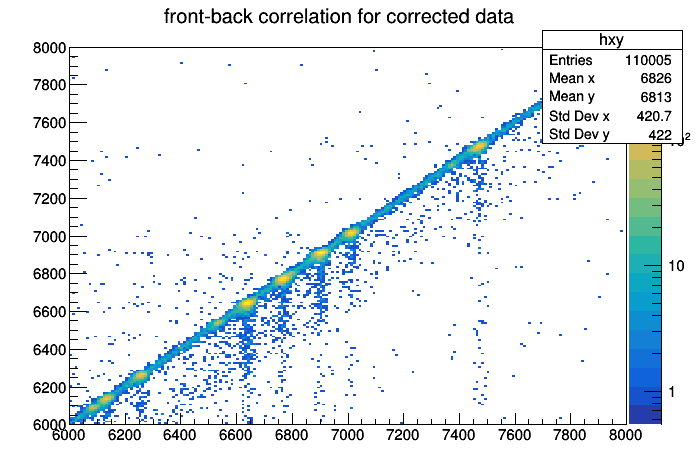

In [22]:
hxy->GetXaxis()->SetRangeUser(6000,8000);
hxy->GetYaxis()->SetRangeUser(6000,8000);
hxy->Draw("colz");
c1->Draw();

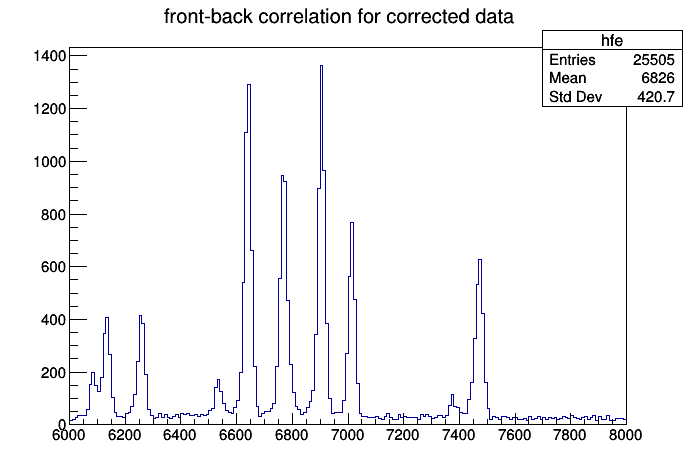

In [23]:
TH1F *hfe=(TH1F*) hxy->ProjectionX("hfe");
hfe->Draw();
c1->Draw();

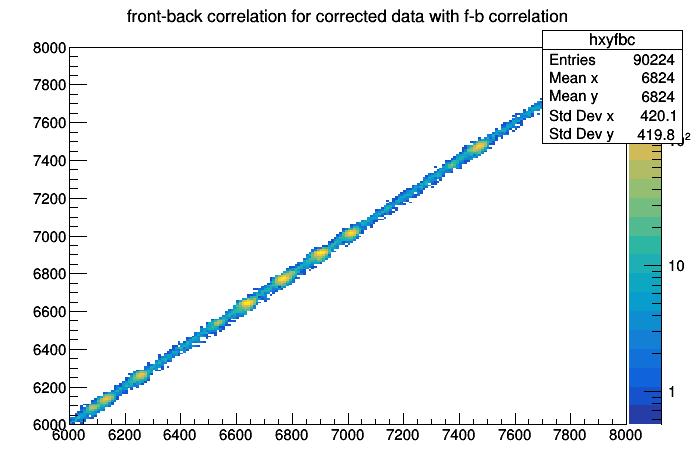

In [24]:
hxyfbc->GetXaxis()->SetRangeUser(6000,8000);
hxyfbc->GetYaxis()->SetRangeUser(6000,8000);
hxyfbc->Draw("colz");
c1->Draw();

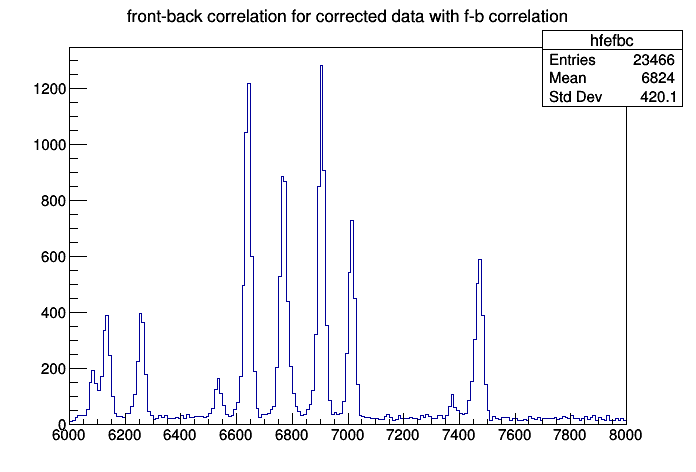

In [25]:
TH1F *hfefbc=(TH1F*) hxyfbc->ProjectionX("hfefbc");
hfefbc->Draw();
c1->Draw();

In [26]:
int jj=0;
for(auto its=mapdssd.begin(); its!=mapdssd.end(); its++) {
    if(jj<20) cout<<its->first<<" "<<its->second.xstrip<<" "<<its->second.ystrip<<" "<<its->second.energy<<endl;
    jj++;
}

1339474900 11 94 6141.49
9122771720 24 121 18331.7
9305277300 27 91 10988.4
9418690550 29 79 16461.8
9423589780 37 100 18753.1
9441339230 43 94 23666.8
9470639590 8 124 15354.3
9531671620 22 108 15308.4
9655958260 26 67 7575.76
9664141370 46 94 4508.02
9703734200 40 127 13927.8
9765657020 40 127 7464.14
9974542190 34 127 15086.1
9977850240 28 104 5240.2
10017904550 11 121 10032.1
10043706620 37 31 6581.24
10062907000 9 124 15359.8
10099563760 33 35 2727.11
10175692380 46 31 5495.81
10186591360 15 97 9575.87


## MWPC

In [27]:
TFile *fmw=new TFile("mwpc.root");
TTree *tmw=(TTree*)fmw->Get("tree");
tmw->SetBranchAddress("energy",&energy);
tmw->SetBranchAddress("timestamp",&timestamp);
tmw->Print();

******************************************************************************
*Tree    :tree      : mwpc                                                   *
*Entries :   353117 : Total =         5667688 bytes  File  Size =    3824341 *
*        :          : Tree compression factor =   1.48                       *
******************************************************************************
*Br    0 :energy    : energy/D                                               *
*Entries :   353117 : Total  Size=    2833530 bytes  File Size  =    1324555 *
*Baskets :       89 : Basket Size=      32000 bytes  Compression=   2.14     *
*............................................................................*
*Br    1 :timestamp : timestamp/l                                            *
*Entries :   353117 : Total  Size=    2833809 bytes  File Size  =    2497325 *
*Baskets :       89 : Basket Size=      32000 bytes  Compression=   1.13     *
*...................................................

In [28]:
tmw->Scan("timestamp:energy","","colsize=15",10,1);

************************************************
*    Row   *       timestamp *          energy *
************************************************
*        1 *   1967773996860 *           15365 *
*        2 *   1018727462730 *           15699 *
*        3 *   2771711086400 *           15097 *
*        4 *    934774734690 *              24 *
*        5 *   2435449424700 *           16088 *
*        6 *    422204325350 *            2796 *
*        7 *   3178976019570 *            3133 *
*        8 *   2887172375060 *            7291 *
*        9 *   1924594027780 *           12244 *
*       10 *   2430242405260 *            3944 *
************************************************


In [29]:
map<ULong64_t, Float_t> mapmw1;//map for mwpc
 nentries = tmw->GetEntriesFast();
for (Long64_t jentry=0; jentry<nentries;jentry++) {
    tmw->GetEntry(jentry);
    mapmw1.insert(pair<ULong64_t,Float_t>(timestamp,energy));
    if(nentries%100000==0) cout<<jentry<<endl;
}
cout<<"Total number of mwpc events = "<<mapmw1.size()<<endl;    
fmw->Close();

Total number of mwpc events = 353117


 0         78196010     3.0
 1        259521960   32763.0
 2        574208200   32726.0
 3        750230460    24.0
 4       1086207510    15.0
 5       1363535160    24.0
 6       1364841100   32749.0
 7       1426179500     5.0
 8       1495511510    34.0
 9       1731485990     8.0


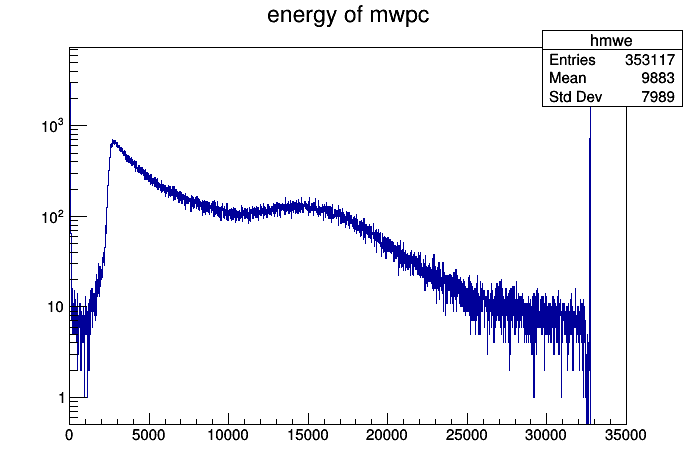

In [30]:
auto imw=mapmw1.begin();//
TH1F *hmwe=new TH1F("hmwe","energy of mwpc",3500,0,35000);
for(int i=0; i<mapmw1.size(); i++) {
    if(i<10) {
        sout.Form("%2d  %15llu   %5.1f" , i, imw->first, imw->second);
       cout<<sout<<endl;
    }
    hmwe->Fill(imw->second);
    imw++;
}
hmwe->Draw();
c1->SetLogy();
c1->Draw();//trheshold:1000

## MWPC 与DSSD符合时间窗

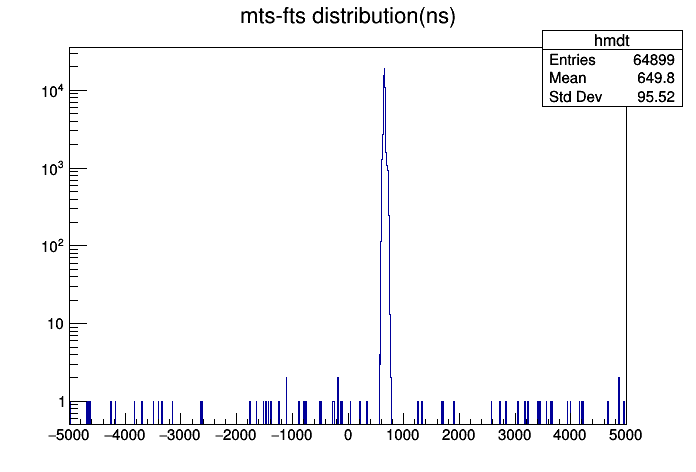

In [31]:
twindow=5000;//ns
TH1I *hmdt=new TH1I("hmdt","mts-fts distribution(ns)",1000,-5000,5000);
for(auto idts=mapdssd.begin(); idts!=mapdssd.end();idts++) {
    auto imts=mapmw1.lower_bound( (idts->first)-twindow);
    while(imts!=mapmw1.end()) {
        if(imts->first >= (idts->first) + twindow) break;
        int dt=imts->first-idts->first;
        hmdt->Fill(dt);
        imts++;
    }   
}
hmdt->Draw();
c1->SetLogy();
c1->Draw();

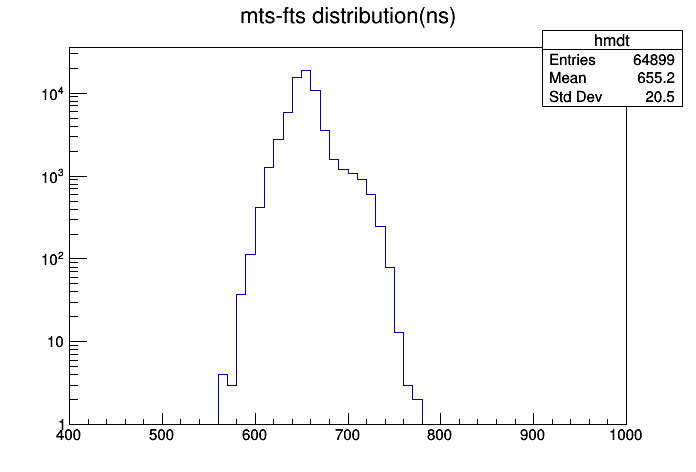

In [32]:
hmdt->GetXaxis()->SetRangeUser(400,1000);
hmdt->Draw();
c1->Draw();

### 从上图看符合时间窗中心位置为650，宽度为-100,100
### mwpc的timestamp减去offset，与DSSD正面时间对齐

In [33]:
toffset=650;
map<ULong64_t, Float_t> mapmw;
for(auto imts=mapmw1.begin(); imts!=mapmw1.end();imts++) 
    mapmw.insert(pair<ULong64_t,Float_t>(imts->first - toffset, imts->second));

### 观察符合时间窗内的关联事件

In [34]:
twindow=100;//ns
TH1F *hmwec=new TH1F("hmwec","energy of mwpc coincided with DSSD ",3500,0,35000);
TH1F *hdsec=new TH1F("hdsec","energy of DSSD coincided with MWPC ",3500,0,35000);
hmdt->Reset();
for(auto idts=mapdssd.begin(); idts!=mapdssd.end();idts++) {
    auto imts=mapmw.lower_bound( (idts->first)-twindow);
    while(imts!=mapmw.end()) {
        if(imts->first >= (idts->first) + twindow) break;
        int dt=imts->first-idts->first;
        hmwec->Fill(imts->second);
        hdsec->Fill(idts->second.energy);
        imts++;
    }   
}

### 与DSSD符合的MWPC能谱
MWPC能谱中超界部分在DSSD符合能谱中消失，意味着这部分是由很重的余核引起的，没有传出MPWC，直接阻停在内部。

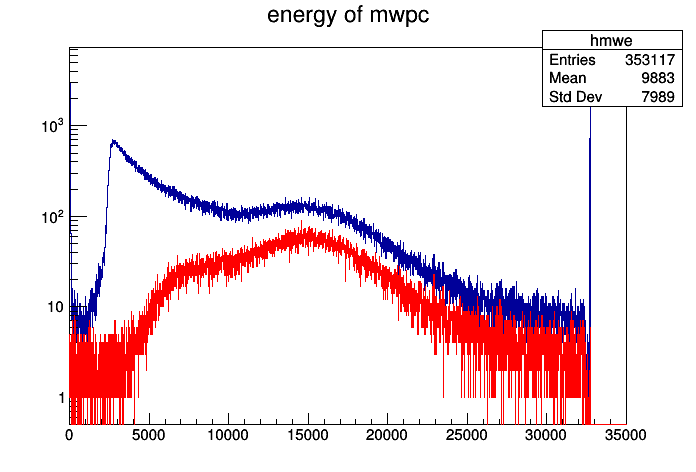

In [35]:
hmwe->Draw();
hmwec->SetLineColor(kRed);
hmwec->Draw("same");
c1->SetLogy();
c1->Draw();

### 与MWPC符合的DSSD能谱
从下面图的特征看，alpha峰即熔合蒸发余核的衰变产物只在无MWPC符合时出现。即alpha衰变的产生事件与束流注入事件不同步，衰变事件的时间应在粒子注入之后。将mwpc作为veto，可选出无入射粒子干扰的衰变谱。
0-2000范围内的DSSD能谱是由低能衰变产物和入射轻粒子(p,d等)，引起的。入射轻粒子在MWPC上能量沉积太小，不产生信号，但一般都有足够的能量穿透注入探测器。这部分由注入探测器后的其他Si探测器进行测量，从DSSD谱中将其veto掉(这部分没有包含在当前的数据中)。

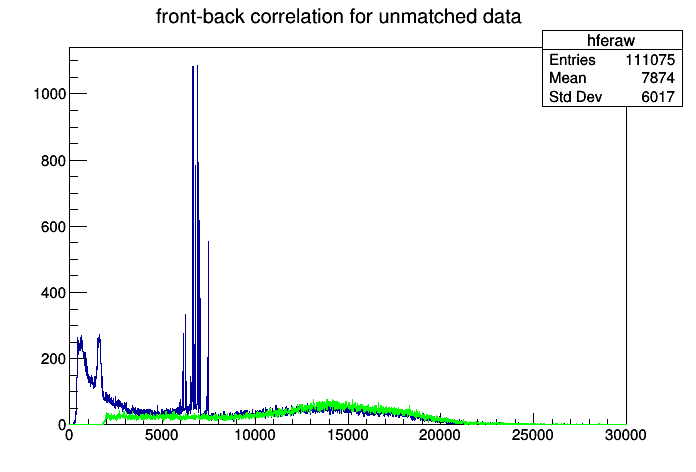

In [36]:
hferaw1->Draw();//raw
hdsec->SetLineColor(kGreen);
hdsec->Draw("same");//coincide with MWPC
c1->SetLogy(0);
c1->Draw();